# Automated Cervical Spine MRI Analysis

### This series of posts describes the creation of a deep learning model to interpret MRI scans of the cervical spine. The output of the deep learning model is then used to predict surgical outcome in a cohort of patients undergoing surgery for Degenerative Cervical Myelopathy



## Introduction

Degenerative cervical myelopathy (DCM) is a chronic disease that causes progressive non-traumatic compression of the cervical spinal cord. The following image shows an a schematic representation of the constellation of anatomic changes that occur in DCM that lead to compression of the cervical spinal cord. 

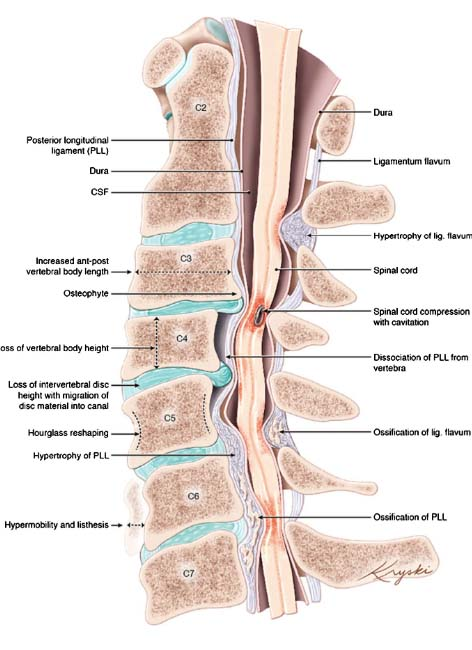

As the compression of the spinal cord worsens DCM can cause neurologic deficits, impaired mobility, and significant impairment in quality of life. The CSM-International and CSM-North America clinical trials are the two largest clinical trials that studied patients with DCM. The two studies together included 757 patients with DCM. Every patient had an MRI scan of the cervical spine and then went on to have surgery. The patients were then assessed 6 months, 12 months, and 24 months following surgery. 

#### This dataset contained a sufficient number of MRIs to train a deep learning model to recognize signs of DCM. 

## Data Representation

Each patient had a pre-operative MRI of the cervical spine that at a minimum included a T2-weighted and T1-weighted sequence with axial and saggital series. Unfortunately the MRIs were stored in various formats. The majority were dicom files, but many were stored as a tiled series of jpegs or pngs. In addition some MRIs were missing or corrupted. 

Table 1 - Summary of MRI parameters extracted from dicom files across the study population. 

| Parameter       | Range          | Median    |
|-----------------|----------------|-----------|
| Slice Thickness | 2.5 - 6mm      | 4mm       |
| Image width     | 256-512 px     | 512 px    |
| Image height    | 256-512 px     | 512 px    |
| Series Length   | 16 - 83 images | 62 images |

To maintain consistency we used only the MRIs that were stored in dicom format. We chose to focus on the T2-weighted axial sequence. Each axial sequence contained approximately 60 slices that spanned from the foramen magnum to the upper thoracic spine. We extracted the T2-weighted axial sequence for each patient and stored it as a new dicom file. This was accomplished manually using OsiriX Lite. 

Here is an example series of axial images from a single patient tiled in a single image. 
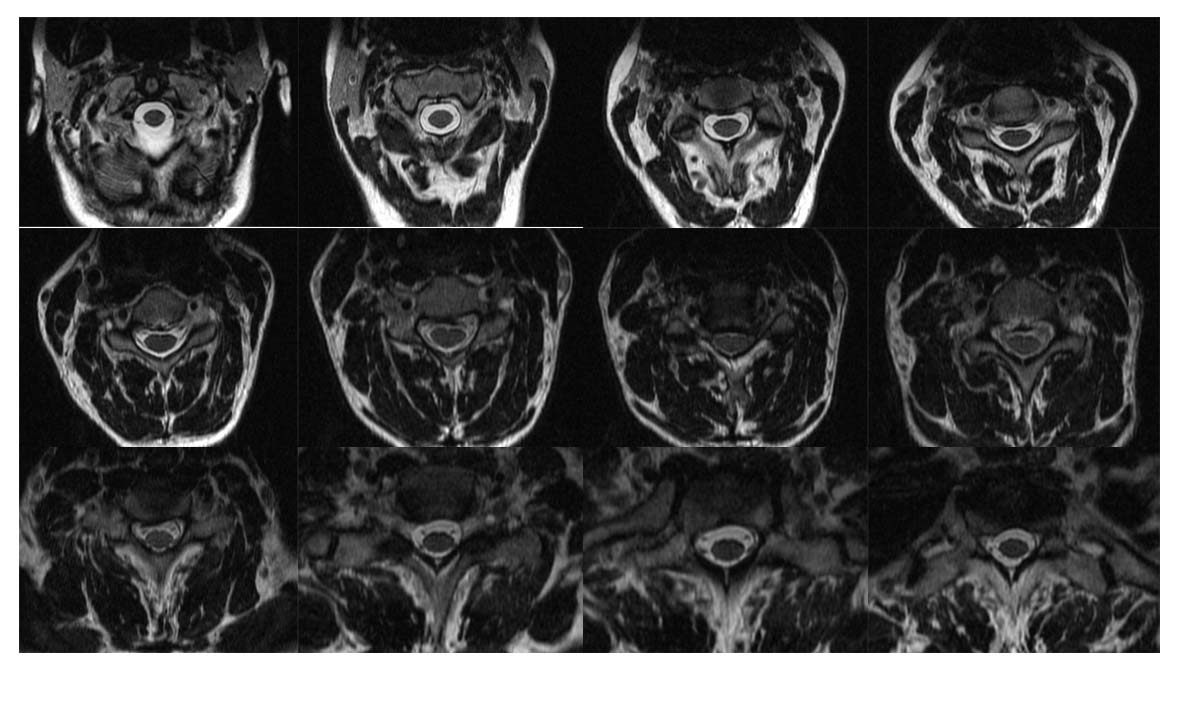
The set of images presented to the deep learning model included each T2-weighted axial image from each patient. Thus each image was represented independently. The information relating to which patient each image originated from and the ordering of the images was lost. This was an intentional comprimise. The spinal cord and canal looks fairly similar regardless of which level of the spinal cord the image originated from. We felt the deep learning model would be able to generalize features from this data representation. Representing our data this way allowed us to have many more images for model training. 

## Data Labelling

There are a number of pathalogic changes that can be identified in an MRI scan of a patient with DCM. The full range of imaging findings are summarized in this 2016 article from Neurosurgical Focus. (https://www.ncbi.nlm.nih.gov/pubmed/27246488) 

To summarize, the structural changes related to DCM that can be detected on MRI include:
* Spinal cord compression
* Cervical Stenosis
* Cord signal change
* Ligamentous Pathology
* Spondylolysthesis
* Sagittal Alignment 

We chose to focus our deep learning model on detecting spinal cord compression for the following reasons:
* Spinal cord compression is highly sensive for myelopathy. The following 2010 study of 103 patients (https://www.ncbi.nlm.nih.gov/pubmed/20150835) found that spinal cord compression was 100% sensitive and 79.6% specific for clinical myelopathy. 
* Spinal cord compression can be reliably graded on T2-weighted axial images using a number of grading systems. The inter-rater reliability of these grading systems is greater than 80% and in some studies was over 95%. (https://www.ncbi.nlm.nih.gov/pubmed/27246488)
* Even though spinal cord compression is not 100% specific for clinical myelopathy the presence of spinal cord compression is a concerning finding that warrents continued follow up. 

For these reasons we believed that a deep learning model capable of reliably detecting spinal cord compression would serve as a useful screening tool for detecting patients that had symptoms of clinical myelopathy or were at risk of developing clinical myelopathy. 

To standardize the data labelling we used the qualitative criteria outlined in this 2010 study. https://www.ncbi.nlm.nih.gov/pubmed/20150835. Importantly we did not differentiate between Partial spinal cord compression and circumfrential spinal cord compression. Instead we defined spinal cord compression as any indentation on the spinal cord parenchyma which changed the contour of the spinal cord perimeter. Labelers assessed each T2-weighted axial slice and assigned a label of:
* 1: evidence of partial or circumfrential spinal cord compression or 
* 0: no spinal cord compression. 

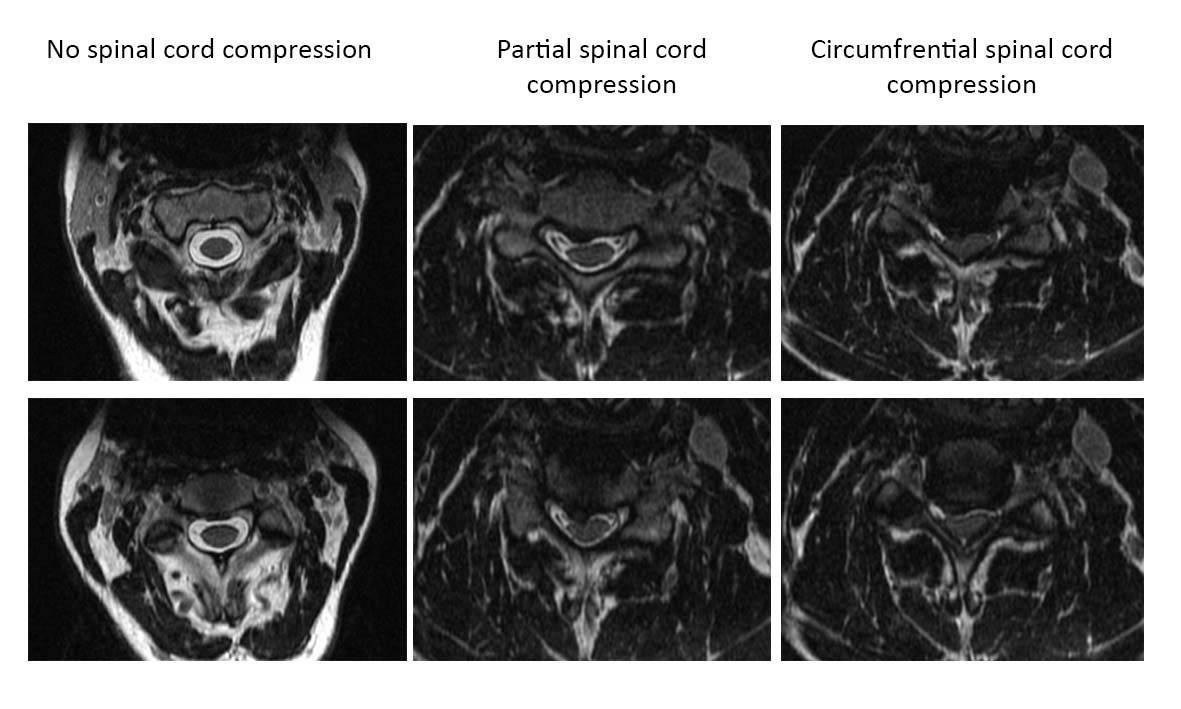



Image labelling was completed using the dicomlabeler.py script which can also be found in the main repository. This script makes use of the pydicom package. This script expects images to be stored in the following file structure:
```
 Root_Directory
 |
 +-- dicomlabeler.py
 |    
 +-- Patient1
 |  |  
 |  +-- ax_t2
 |      |
 |      +-- DicomImage1.dcm
 |      +-- DicomImage2.dcm
 |      +-- DicomImage3.dcm
 |      ...
 |      +-- DicomImage62.dcm
 |    
 +-- Patient2
 |  |  
 |  +-- ax_t2
 |      |
 |      +-- DicomImage1.dcm
 |      +-- DicomImage2.dcm
 |      +-- DicomImage3.dcm
 |      ...
 |      +-- DicomImage62.dcm
 |    
 +-- etc.
```
The script outputs a file called compression_label.csv into the patient directory containing the labels. 

```python
import os
from os.path import join, getsize, dirname
from pprint import pprint
import numpy as np
import csv
import pydicom
from pydicom.filereader import read_dicomdir

import matplotlib.pyplot as plt 
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *


#Define list of patient ids
patient_id = []
#Define lists for filepaths
ax_t2_filepath = []
#Define the root directory
rootDir = os.path.join(os.path.dirname(os.path.realpath(__file__)),'images')
#Fill list of patient ids
patient_id = os.listdir(rootDir)
print patient_id
#Current patient id
ident = int(raw_input('Enter Reference:'))
print patient_id[ident]

#Function, take patient id, output list of file paths for ax t2 dicoms
def paths_ax_t2(patient_id):
	subDir = os.path.join(rootDir,patient_id,'ax_t2')
	for root, dirs, files in os.walk(subDir):
		for fname in files:
			if fname.endswith('.dcm'):
				img_path = os.path.join(root,fname)
				ax_t2_filepath.append(img_path)
	return ax_t2_filepath

t2_filepath = paths_ax_t2(patient_id[ident])
print(len(t2_filepath))

#Get ref file
RefDs = pydicom.read_file(t2_filepath[0])
#Load dimensions of the dicom sequence
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(t2_filepath))

# Make empty array based on extracted dimensions
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in t2_filepath:
    # read the file
    ds = pydicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, t2_filepath.index(filenameDCM)] = ds.pixel_array 
    
plt.ion()
category = []
csvfile = os.path.join(rootDir,patient_id[ident],'compression_label.csv')
for i in range(len(t2_filepath)):
	plt.imshow(ArrayDicom[:, :, i])
	plt.show()
	plt.pause(0.001)
	category.append(raw_input('compression?: '))
	print("Remaining: %d" % (len(t2_filepath)-i))


with open(csvfile, "w") as output:
	writer = csv.writer(output, lineterminator='\n')
	for val in category:
		writer.writerow([val])


```

Two labelers independantly labelled 110 patients, corresponding to 6093 individual axial images. The remaining 270 images were not labelled at this stage and were kept for model testing. 


|              *           | Images Labelled Compressed | Images Labelled Not-Compressed |
| ------------------------------------ |---------------------------- |-------------------------------- |
| Labeler 1                         | 1423 / 6093 (23.4%)        | 4670 / 6093 (76.6%)            |
| Labeeler 2                         | 1253 / 6093 (20.6%)        | 4840 / 6093 (79.4%)            |
| Percent agreement between labelers | 88.1%                      | 96.4%                          |

As you can see the two labellers had excellent agreement (96.4%) on images that were not compressed. The agreement was still good (88.1%) on compressed images. We examined the images where there was disagreement between the labellers and we found that these images tended to be ones with minimal partial compression. 

We next wrote the dicomconverter.py script. This script took as in input the T2-weighted axial series of images and the .csv file containing the labels assigned by the two labellers. It output a series of uncompressed .jpeg images with the label in the filename

compression_label.index.jpeg

ex)
* notcompressed.1.jpeg (notcompressed indicated an image that was labelled notcompressed by both labelers)
* notcompressed.2.jpeg
* notcompressed.3.jpeg
* compressed.4.jpeg (compresed indicated an image that was labelled as compressed by both labelers)
* pcompressed.5.jpeg (pcompressed indicated an image with disagreement between the labelers)

#### In the next post I will go over how we designed and trained a deep learning model to classify these images. 

#### Zamir Merali